In [41]:
%reset -f
import sys
print("Python version")
print(sys.version)

Python version
3.7.9 (tags/v3.7.9:13c94747c7, Aug 17 2020, 18:58:18) [MSC v.1900 64 bit (AMD64)]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

In [43]:
#Coingecko api
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [44]:
import time
import datetime

def edit_prices_dict(d): 
    df=pd.DataFrame(d)
    #Saving dates
    dates=df['prices'].map(lambda x: x[0])  
    #Filtering the values without dates
    df=df.applymap(lambda x: x[1])
    df['dates']=dates 
    df["dates"] = pd.to_datetime(df['dates'], unit='ms')
    df.index = df["dates"]
    df=df[['prices','total_volumes']]
    return df

In [45]:
#dd/mm/yyyy
from_date="01/01/2021"
to_date="27/11/2021"
from_unix = time.mktime(datetime.datetime.strptime(from_date, "%d/%m/%Y").timetuple())
to_unix = time.mktime(datetime.datetime.strptime(to_date, "%d/%m/%Y").timetuple())

token = "bitcoin"; vs_currency = "usd"

response=cg.get_coin_market_chart_range_by_id(id = token, vs_currency = vs_currency, from_timestamp = from_unix, to_timestamp = to_unix)

In [46]:
df = edit_prices_dict(response)
print(df.shape)
df.tail()

(330, 2)


,prices,total_volumes
dates,,
2021-11-22,59139.779280,2.574343e+10
2021-11-23,56386.856853,3.400147e+10
2021-11-24,57748.793174,3.642119e+10
2021-11-25,57198.183846,3.169537e+10
2021-11-26,58897.846983,3.372110e+10


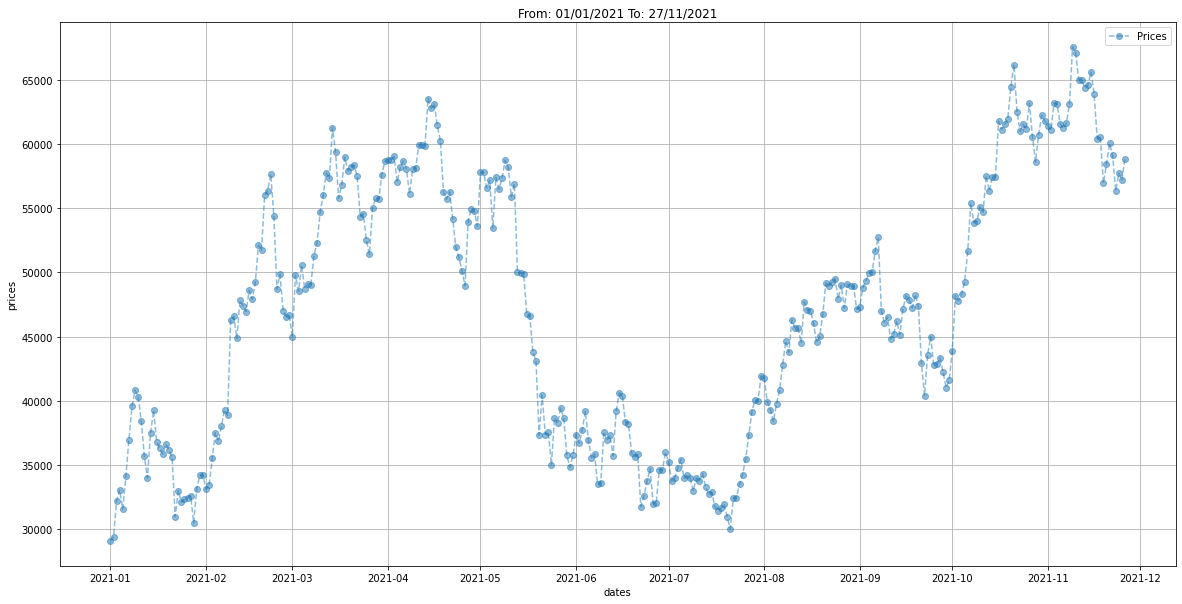

In [47]:
fig=plt.figure(figsize=(20, 10))
plt.plot(df['prices'], '--o', label = 'Prices', alpha = 0.5)
plt.title('From: ' + from_date + ' To: ' + to_date) 
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)

In [48]:
# Esto hay que hacerlo pues es con la info de hoy predecir mañana
df["y"] = df["prices"].shift(-1)
df.tail(5)

,prices,total_volumes,y
dates,,,
2021-11-22,59139.779280,2.574343e+10,56386.856853
2021-11-23,56386.856853,3.400147e+10,57748.793174
2021-11-24,57748.793174,3.642119e+10,57198.183846
2021-11-25,57198.183846,3.169537e+10,58897.846983
2021-11-26,58897.846983,3.372110e+10,NaN


#### Se calculan indicadores para ese día

In [49]:
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
# MovingAverage
#values_ma = [5,15,30]
#
#for i in values_ma:
#    df["ma_close_" + str(i)] = df["close"].rolling(window=i).mean()
#    df["ma_volume_" + str(i)] = df["volume"].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = [5,15,30]

for i in values_ema:
    df["ema_" + str(i)] = df["prices"].ewm(span = i, adjust = False).mean()
    
# RSI https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = [7,14,21]
close = df['prices']

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    #roll_up1 = up.ewm(span=i).mean()
    #roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    #RS1 = roll_up1 / roll_down1
    #RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    #df["rsi_ewma_" + str(i)] = RSI1.values
    df["rsi_sma_" + str(i)]  = RSI2.values
    
# BollingerBand
values_bollinger = [5,10,20]
for i in values_bollinger:
    df['bollinger_upper_' + str(i)] = df['prices'].rolling(window=i).mean() + (df['prices'].rolling(window=i).std()  * 2)
    df['bollinger_lower_' + str(i)] = df['prices'].rolling(window=i).mean() - (df['prices'].rolling(window=i).std()  * 2)

# Rate of change
# values_rc = [5,15,30]
# for i in values_rc:
#     df["rc_" + str(i)] = df["prices"].pct_change(periods = i)
    
# Stochastic Oscillators
#values_so = [5,15,30]
#for i in values_so:
#    lowest = df["low"].rolling(window = i).min()
#    high = df["high"].rolling(window = i).max()
#    df["so_" + str(i)] = ((df['close'] -lowest)/(high - lowest))*100
#    df["so_%D" + str(i)] = df["so_" + str(i)].rolling(window = i).mean()

In [50]:
# Get feature from dates
#df['month'] = df.index.month.astype(str)
#df['day'] = df.index.day
#df['weekday'] = df.index.dayofweek.astype(str)
#df['dayofyear'] = df.index.dayofyear

In [51]:
df.sample()

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20
dates,,,,,,,,,,,,,,,
2021-09-11,44802.606402,3.805199e+10,45196.488278,46815.949359,47938.885766,46982.132109,27.899253,36.933303,40.650314,53586.653584,41269.962633,53800.680083,43588.748929,52310.603026,44816.92053


In [52]:
#df["y"] = 100*( (df["y"] - df["prices"])/df["prices"])   
#print(df.shape)
#df.sample()

In [53]:
all_columns = list(df.columns)
keep_columns = [item for item in all_columns if item not in "y"]
print(keep_columns)

['prices', 'total_volumes', 'ema_5', 'ema_15', 'ema_30', 'rsi_sma_7', 'rsi_sma_14', 'rsi_sma_21', 'bollinger_upper_5', 'bollinger_lower_5', 'bollinger_upper_10', 'bollinger_lower_10', 'bollinger_upper_20', 'bollinger_lower_20']


In [54]:
minus = 15 # Es el lag del pasado cuanto pillamos
list_shift = list(range(1, minus))

for i in list_shift:
    for j in keep_columns:
        df[str(j) + "minus" + str(i)] = df[str(j)].shift(i)

C:\Users\AldoFranco\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [55]:
df.tail(2)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi_sma_14minus13,rsi_sma_21minus13,bollinger_upper_5minus13,bollinger_lower_5minus13,bollinger_upper_10minus13,bollinger_lower_10minus13,bollinger_upper_20minus13,bollinger_lower_20minus13,pricesminus14,total_volumesminus14,ema_5minus14,ema_15minus14,ema_30minus14,rsi_sma_7minus14,rsi_sma_14minus14,rsi_sma_21minus14,bollinger_upper_5minus14,bollinger_lower_5minus14,bollinger_upper_10minus14,bollinger_lower_10minus14,bollinger_upper_20minus14,bo

In [56]:
print("Shape: " + str(df.shape))
df.dropna(inplace = True)
print("Shape: " + str(df.shape))

Shape: (330, 211)
Shape: (294, 211)


In [57]:
df.tail(2)

,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi_sma_14minus13,rsi_sma_21minus13,bollinger_upper_5minus13,bollinger_lower_5minus13,bollinger_upper_10minus13,bollinger_lower_10minus13,bollinger_upper_20minus13,bollinger_lower_20minus13,pricesminus14,total_volumesminus14,ema_5minus14,ema_15minus14,ema_30minus14,rsi_sma_7minus14,rsi_sma_14minus14,rsi_sma_21minus14,bollinger_upper_5minus14,bollinger_lower_5minus14,bollinger_upper_10minus14,bollinger_lower_10minus14,bollinger_upper_20minus14,bo

In [58]:
df.dtypes.value_counts()

float64    211
dtype: int64

In [59]:
print(df.shape)
cutoff = 250

train = df[0:cutoff]
print(train.shape)

test = df[cutoff:df.shape[0]]
print(test.shape)
test.tail(1)

(294, 211)
(250, 211)
(44, 211)


,prices,total_volumes,y,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi_sma_14minus13,rsi_sma_21minus13,bollinger_upper_5minus13,bollinger_lower_5minus13,bollinger_upper_10minus13,bollinger_lower_10minus13,bollinger_upper_20minus13,bollinger_lower_20minus13,pricesminus14,total_volumesminus14,ema_5minus14,ema_15minus14,ema_30minus14,rsi_sma_7minus14,rsi_sma_14minus14,rsi_sma_21minus14,bollinger_upper_5minus14,bollinger_lower_5minus14,bollinger_upper_10minus14,bollinger_lower_10minus14,bollinger_upper_20minus14,bo

In [60]:
X_train = train.drop(columns = ["y"]); print(X_train.shape)
X_test = test.drop(columns = ["y"]); print(X_test.shape)
y_train = train[["y"]]; print(y_train.shape)
y_test = test[["y"]]; print(y_test.shape)

(250, 210)
(44, 210)
(250, 1)
(44, 1)


In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()

In [62]:
X_train_ss = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
print(X_train_ss.shape)
X_test_ss = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
print(X_test_ss.shape)

(250, 210)
(44, 210)


In [63]:
X_train_ss.sample()

,prices,total_volumes,ema_5,ema_15,ema_30,rsi_sma_7,rsi_sma_14,rsi_sma_21,bollinger_upper_5,bollinger_lower_5,bollinger_upper_10,bollinger_lower_10,bollinger_upper_20,bollinger_lower_20,pricesminus1,total_volumesminus1,ema_5minus1,ema_15minus1,ema_30minus1,rsi_sma_7minus1,rsi_sma_14minus1,rsi_sma_21minus1,bollinger_upper_5minus1,bollinger_lower_5minus1,bollinger_upper_10minus1,bollinger_lower_10minus1,bollinger_upper_20minus1,bollinger_lower_20minus1,pricesminus2,total_volumesminus2,ema_5minus2,ema_15minus2,ema_30minus2,rsi_sma_7minus2,rsi_sma_14minus2,rsi_sma_21minus2,bollinger_upper_5minus2,bollinger_lower_5minus2,bollinger_upper_10minus2,bollinger_lower_10minus2,bollinger_upper_20minus2,bollinger_lower_20minus2,pricesminus3,total_volumesminus3,ema_5minus3,ema_15minus3,ema_30minus3,rsi_sma_7minus3,rsi_sma_14minus3,rsi_sma_21minus3,bollinger_upper_5minus3,bollinger_lower_5minus3,bollinger_upper_10minus3,bollinger_lower_10minus3,bollinger_upper_20minus3,bollinger_lower_20minus3,pricesminus4,total_volumesminus4,ema_5minus4,ema_15minus4,ema_30minus4,rsi_sma_7minus4,rsi_sma_14minus4,rsi_sma_21minus4,bollinger_upper_5minus4,bollinger_lower_5minus4,bollinger_upper_10minus4,bollinger_lower_10minus4,bollinger_upper_20minus4,bollinger_lower_20minus4,pricesminus5,total_volumesminus5,ema_5minus5,ema_15minus5,ema_30minus5,rsi_sma_7minus5,rsi_sma_14minus5,rsi_sma_21minus5,bollinger_upper_5minus5,bollinger_lower_5minus5,bollinger_upper_10minus5,bollinger_lower_10minus5,bollinger_upper_20minus5,bollinger_lower_20minus5,pricesminus6,total_volumesminus6,ema_5minus6,ema_15minus6,ema_30minus6,rsi_sma_7minus6,rsi_sma_14minus6,rsi_sma_21minus6,bollinger_upper_5minus6,bollinger_lower_5minus6,bollinger_upper_10minus6,bollinger_lower_10minus6,bollinger_upper_20minus6,bollinger_lower_20minus6,pricesminus7,total_volumesminus7,ema_5minus7,ema_15minus7,ema_30minus7,rsi_sma_7minus7,rsi_sma_14minus7,rsi_sma_21minus7,bollinger_upper_5minus7,bollinger_lower_5minus7,bollinger_upper_10minus7,bollinger_lower_10minus7,bollinger_upper_20minus7,bollinger_lower_20minus7,pricesminus8,total_volumesminus8,ema_5minus8,ema_15minus8,ema_30minus8,rsi_sma_7minus8,rsi_sma_14minus8,rsi_sma_21minus8,bollinger_upper_5minus8,bollinger_lower_5minus8,bollinger_upper_10minus8,bollinger_lower_10minus8,bollinger_upper_20minus8,bollinger_lower_20minus8,pricesminus9,total_volumesminus9,ema_5minus9,ema_15minus9,ema_30minus9,rsi_sma_7minus9,rsi_sma_14minus9,rsi_sma_21minus9,bollinger_upper_5minus9,bollinger_lower_5minus9,bollinger_upper_10minus9,bollinger_lower_10minus9,bollinger_upper_20minus9,bollinger_lower_20minus9,pricesminus10,total_volumesminus10,ema_5minus10,ema_15minus10,ema_30minus10,rsi_sma_7minus10,rsi_sma_14minus10,rsi_sma_21minus10,bollinger_upper_5minus10,bollinger_lower_5minus10,bollinger_upper_10minus10,bollinger_lower_10minus10,bollinger_upper_20minus10,bollinger_lower_20minus10,pricesminus11,total_volumesminus11,ema_5minus11,ema_15minus11,ema_30minus11,rsi_sma_7minus11,rsi_sma_14minus11,rsi_sma_21minus11,bollinger_upper_5minus11,bollinger_lower_5minus11,bollinger_upper_10minus11,bollinger_lower_10minus11,bollinger_upper_20minus11,bollinger_lower_20minus11,pricesminus12,total_volumesminus12,ema_5minus12,ema_15minus12,ema_30minus12,rsi_sma_7minus12,rsi_sma_14minus12,rsi_sma_21minus12,bollinger_upper_5minus12,bollinger_lower_5minus12,bollinger_upper_10minus12,bollinger_lower_10minus12,bollinger_upper_20minus12,bollinger_lower_20minus12,pricesminus13,total_volumesminus13,ema_5minus13,ema_15minus13,ema_30minus13,rsi_sma_7minus13,rsi_sma_14minus13,rsi_sma_21minus13,bollinger_upper_5minus13,bollinger_lower_5minus13,bollinger_upper_10minus13,bollinger_lower_10minus13,bollinger_upper_20minus13,bollinger_lower_20minus13,pricesminus14,total_volumesminus14,ema_5minus14,ema_15minus14,ema_30minus14,rsi_sma_7minus14,rsi_sma_14minus14,rsi_sma_21minus14,bollinger_upper_5minus14,bollinger_lower_5minus14,bollinger_upper_10minus14,bollinger_lower_10minus14,bollinger_upper_20minus14,boll

In [69]:
import tensorflow as tf
# https://keras.io/api/losses/

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units = 5000, activation='relu', input_shape=(X_train_ss.shape[1],)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units = 4000, activation='relu'))
model.add(tf.keras.layers.Dense(units = 3000, activation='relu'))
model.add(tf.keras.layers.Dense(units = 1, activation='relu'))

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

model.compile(optimizer=optimizer, 
              loss='mean_absolute_error')

In [70]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 5000)              1055000   
                                                                 
 dropout_6 (Dropout)         (None, 5000)              0         
                                                                 
 dense_29 (Dense)            (None, 4000)              20004000  
                                                                 
 dense_30 (Dense)            (None, 3000)              12003000  
                                                                 
 dense_31 (Dense)            (None, 1)                 3001      
                                                                 
Total params: 33,065,001
Trainable params: 33,065,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tqdm import tqdm_notebook as tqdm
from tqdm.keras import TqdmCallback
%matplotlib inline

NUM_EPOCHS = 50
BATCH_SIZE = 100
history = model.fit(X_train_ss, y_train,
                    epochs = NUM_EPOCHS,
                    batch_size  = BATCH_SIZE,
                    validation_split = 0.2,
                    #validation_data=(X_test, y_test),
                    callbacks=[TqdmCallback( verbose = 0)], # coloca una barra de progreso
                    verbose = 1)

0epoch [00:00, ?epoch/s]

Epoch 1/50
2/2 [==============================] - 1s 451ms/step - loss: 2291.0093 - val_loss: 2278.8870
Epoch 2/50
2/2 [==============================] - 1s 318ms/step - loss: 2171.4438 - val_loss: 2378.8311
Epoch 3/50
2/2 [==============================] - 1s 320ms/step - loss: 2227.2859 - val_loss: 2432.1172
Epoch 4/50
2/2 [==============================] - 1s 311ms/step - loss: 2287.1318 - val_loss: 2354.7656
Epoch 5/50
2/2 [==============================] - 1s 309ms/step - loss: 2214.7166 - val_loss: 2291.3794
Epoch 6/50
2/2 [==============================] - 1s 319ms/step - loss: 2240.9006 - val_loss: 2261.0093
Epoch 7/50
2/2 [==============================] - 1s 315ms/step - loss: 2176.8438 - val_loss: 2347.1521
Epoch 8/50
2/2 [==============================] - 1s 301ms/step - loss: 2237.2480 - val_loss: 2518.4814
Epoch 9/50
2/2 [==============================] - 1s 327ms/step - loss: 2278.0505 - val_loss: 2431.8459
Epoch 10/50
2/2 [==============================] - 1s 337ms/step

In [75]:
test_loss, test_metric = model.evaluate(X_test_ss, y_test)

2/2 [==============================] - 0s 18ms/step - loss: 1823.2805


TypeError: cannot unpack non-iterable float object

In [76]:
plt.plot(history.history['mean_absolute_error'],'r')
plt.plot(history.history['val_mean_absolute_error'],'g')
plt.xticks(np.arange(0, NUM_EPOCHS, 50.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("mean_absolute_error")
plt.title("Training vs Validation")
plt.legend(['train','validation'])
plt.show()

KeyError: 'mean_absolute_error'

In [260]:
predictions = model.predict(X_test_ss)
predictions = pd.DataFrame(np.array(predictions), index = y_test.index, columns=["y_pred"])

C:\Users\AldoFranco\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  
C:\Users\AldoFranco\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


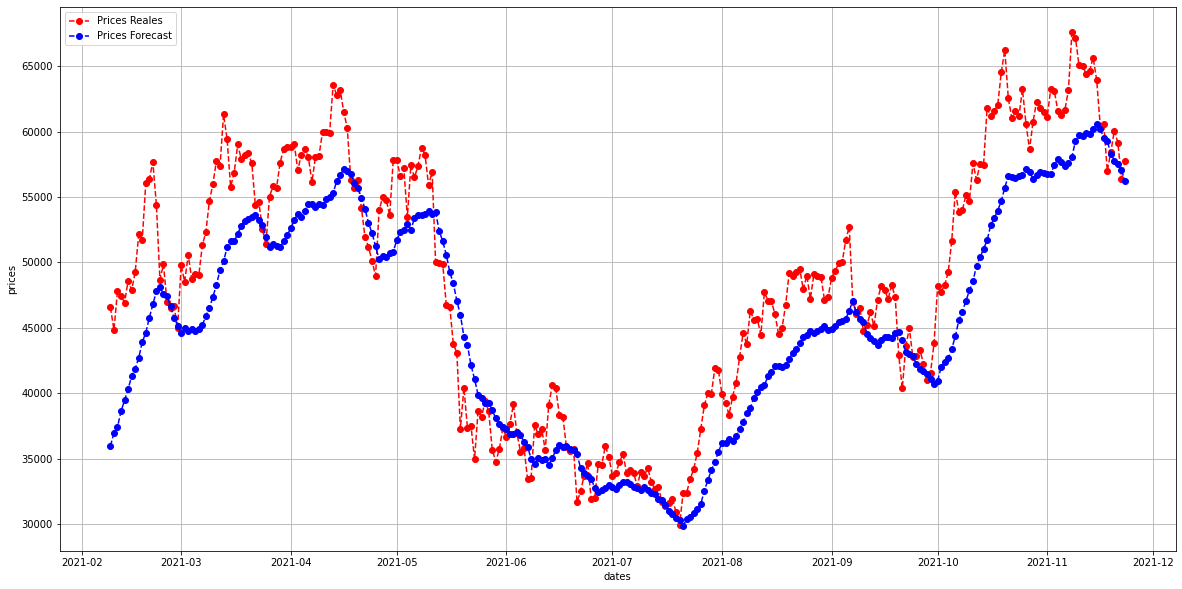

In [261]:
fig=plt.figure(figsize=(20, 10))
plt.plot(y_test['y'], '--bo', label = 'Prices Reales', color = "r")
plt.plot(predictions["y_pred"], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

### Telegram

In [267]:
import telepot

bot_token = '1653124784:AAFpL0qlC_ybadcbFX6jKagauRFpiFpSf1E'
chatID = '-1001701018194'

bot = telepot.Bot(bot_token)

In [268]:
#ot.sendMessage(bot_chatID, "HALA")
bot.sendPhoto(chatID, photo=open('imagen.png', 'rb'))

{'message_id': 2,
 'from': {'id': 1653124784,
  'is_bot': True,
  'first_name': 'JARVIS',
  'username': 'JARVIS_Walkn_bot'},
 'chat': {'id': -1001701018194,
  'title': 'MoneyIsJustANumber',
  'type': 'supergroup'},
 'date': 1638054568,
 'photo': [{'file_id': 'AgACAgQAAx0EZWN6UgADAmGiuqfH-rFOVy7Tu758eZ2TSaLQAAJYuDEbXYwYUS9o5TdclkEyAQADAgADcwADIgQ',
   'file_unique_id': 'AQADWLgxG12MGFF4',
   'file_size': 785,
   'width': 90,
   'height': 45},
  {'file_id': 'AgACAgQAAx0EZWN6UgADAmGiuqfH-rFOVy7Tu758eZ2TSaLQAAJYuDEbXYwYUS9o5TdclkEyAQADAgADbQADIgQ',
   'file_unique_id': 'AQADWLgxG12MGFFy',
   'file_size': 10308,
   'width': 320,
   'height': 160},
  {'file_id': 'AgACAgQAAx0EZWN6UgADAmGiuqfH-rFOVy7Tu758eZ2TSaLQAAJYuDEbXYwYUS9o5TdclkEyAQADAgADeAADIgQ',
   'file_unique_id': 'AQADWLgxG12MGFF9',
   'file_size': 43068,
   'width': 800,
   'height': 400},
  {'file_id': 'AgACAgQAAx0EZWN6UgADAmGiuqfH-rFOVy7Tu758eZ2TSaLQAAJYuDEbXYwYUS9o5TdclkEyAQADAgADeQADIgQ',
   'file_unique_id': 'AQADWLgxG12MGFF-'